In [3]:
import os

import numpy as np
import pandas as pd
import torch

In [4]:
import pickle

# === Load Pickle Files ===
def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

concatenate_vit_features =  load_pickle('Features/vit_features_av_train.pkl')
concatenate_audio_features = np.load('Features/concatenate/concatenate_waveform_av_train.npy', allow_pickle=True)
labels = np.load('Features/labels_av_train.npy', allow_pickle=True)

concatenate_vit_features_val = load_pickle('Features/vit_features_av_val.pkl')
concatenate_audio_features_val = np.load('Features/concatenate/concatenate_waveform_av_test.npy', allow_pickle=True)
labels_val = np.load('Features/labels_av_val.npy', allow_pickle=True)

concatenate_vit_features_test = load_pickle('Features/vit_features_mul_test.pkl')
concatenate_audio_features_test = np.load('Features/concatenate/concatenate_waveform_mul_test.npy', allow_pickle=True)
labels_test = np.load('Features/labels_mul_test.npy', allow_pickle=True)

In [5]:
concatenate_vit_features[2].shape, concatenate_audio_features[2].shape

(torch.Size([102, 768]), (246, 1024))

In [6]:
labels[1].shape

(250,)

# Train

In [7]:
features_concatenate_list = []
cnt = 0
TARGET_LENGTH = 250

for vit_features, audio_features in zip(concatenate_vit_features, concatenate_audio_features):
    audio_features = torch.tensor(audio_features).cuda()
    vit_features = vit_features.cuda()  # Move to cuda once to avoid repeated calls

    # vit_features to 250 length
    if len(vit_features) < TARGET_LENGTH:
        padding = torch.zeros(TARGET_LENGTH - len(vit_features), vit_features.shape[1], device=vit_features.device)
        vit_features = torch.cat([vit_features, padding], dim=0)
        print(f'check1: padded vit_features to {vit_features.shape}')
    
    # audio_features to 250 length
    if len(audio_features) < TARGET_LENGTH:
        padding = torch.zeros(TARGET_LENGTH - len(audio_features), audio_features.shape[1], device=audio_features.device)
        audio_features = torch.cat([audio_features, padding], dim=0)
        print(f'check2: padded audio_features to {audio_features.shape}')

    concated_feature = torch.cat((vit_features, audio_features), dim=1)
    features_concatenate_list.append(concated_feature)


check1: padded vit_features to torch.Size([250, 768])
check1: padded vit_features to torch.Size([250, 768])
check1: padded vit_features to torch.Size([250, 768])
check2: padded audio_features to torch.Size([250, 1024])
check1: padded vit_features to torch.Size([250, 768])
check1: padded vit_features to torch.Size([250, 768])
check1: padded vit_features to torch.Size([250, 768])
check2: padded audio_features to torch.Size([250, 1024])
check1: padded vit_features to torch.Size([250, 768])
check2: padded audio_features to torch.Size([250, 1024])
check1: padded vit_features to torch.Size([250, 768])
check1: padded vit_features to torch.Size([250, 768])
check1: padded vit_features to torch.Size([250, 768])
check1: padded vit_features to torch.Size([250, 768])
check2: padded audio_features to torch.Size([250, 1024])
check2: padded audio_features to torch.Size([250, 1024])
check1: padded vit_features to torch.Size([250, 768])
check1: padded vit_features to torch.Size([250, 768])
check1: padde

In [8]:
len(features_concatenate_list), features_concatenate_list[0].shape

(401, torch.Size([250, 1792]))

In [9]:
from tqdm.notebook import tqdm
import logging
TARGET_LENGTH = 250

new_features_concatenate_list = []
new_labels = []

for concat, label in tqdm(zip(features_concatenate_list, labels), total=len(labels), desc="Processing"):
    # concat의 길이를 250으로 조절
    if concat.shape[0] < TARGET_LENGTH:
        padding = torch.zeros((TARGET_LENGTH - concat.shape[0], concat.shape[1]), device=concat.device)
        concat = torch.cat([concat, padding], dim=0)
    # label을 250의 길이로 조절. label이 numpy 배열인 경우 텐서로 변환 후 조절
    if isinstance(label, np.ndarray):
        label = torch.from_numpy(label).to(concat.device)
    if len(label) < TARGET_LENGTH:
        padding = torch.zeros(TARGET_LENGTH - len(label), device=concat.device)
        label = torch.cat([label, padding], dim=0)
    
    new_features_concatenate_list.append(concat)
    new_labels.append(label)
    logging.warn(f'{concat.shape}, {label.shape}')


Processing:   0%|          | 0/401 [00:00<?, ?it/s]

/tmp/ipykernel_15651/579627365.py:22: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  logging.warn(f'{concat.shape}, {label.shape}')


In [10]:
labels_train = np.stack([i.cpu().numpy() for i in new_labels])
features_concatenate_list_train = new_features_concatenate_list

In [11]:
len(labels_train), len(features_concatenate_list_train),

(401, 401)

# Validation

In [12]:
features_concatenate_list_val = []
cnt = 0
TARGET_LENGTH = 250
import logging
for vit_features, audio_features in zip(concatenate_vit_features_val, concatenate_audio_features_val):
    audio_features = torch.tensor(audio_features).cuda()
    vit_features = vit_features.cuda()  # Move to cuda once to avoid repeated calls

    # vit_features to 250 length
    if len(vit_features) < TARGET_LENGTH:
        padding = torch.zeros(TARGET_LENGTH - len(vit_features), vit_features.shape[1], device=vit_features.device)
        vit_features = torch.cat([vit_features, padding], dim=0)
        logging.warn(f'check1: padded vit_features to {vit_features.shape}')
    
    # audio_features to 250 length
    if len(audio_features) < TARGET_LENGTH:
        padding = torch.zeros(TARGET_LENGTH - len(audio_features), audio_features.shape[1], device=audio_features.device)
        audio_features = torch.cat([audio_features, padding], dim=0)
        logging.warn(f'check2: padded audio_features to {audio_features.shape}')

    concated_feature = torch.cat((vit_features, audio_features), dim=1)
    features_concatenate_list_val.append(concated_feature)

/tmp/ipykernel_15651/302546984.py:13: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  logging.warn(f'check1: padded vit_features to {vit_features.shape}')
/tmp/ipykernel_15651/302546984.py:19: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  logging.warn(f'check2: padded audio_features to {audio_features.shape}')


In [13]:
from tqdm.notebook import tqdm
import logging

TARGET_LENGTH = 250

new_features_concatenate_list_val = []
new_labels_val = []

for concat, label in tqdm(zip(features_concatenate_list_val, labels_val), total=len(labels_val), desc="Processing"):
    # concat의 길이를 250으로 조절
    if concat.shape[0] < TARGET_LENGTH:
        padding = torch.zeros((TARGET_LENGTH - concat.shape[0], concat.shape[1]), device=concat.device)
        concat = torch.cat([concat, padding], dim=0)
    # label을 250의 길이로 조절. label이 numpy 배열인 경우 텐서로 변환 후 조절
    if isinstance(label, np.ndarray):
        label = torch.from_numpy(label).to(concat.device)
    if len(label) < TARGET_LENGTH:
        padding = torch.zeros(TARGET_LENGTH - len(label), device=concat.device)
        label = torch.cat([label, padding], dim=0)
    
    new_features_concatenate_list_val.append(concat)
    new_labels_val.append(label)
    logging.warn(f'{concat.shape}, {label.shape}')


Processing:   0%|          | 0/140 [00:00<?, ?it/s]

/tmp/ipykernel_15651/2509942390.py:23: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  logging.warn(f'{concat.shape}, {label.shape}')


In [14]:
labels_val = np.stack([i.cpu() for i in new_labels_val])
features_concatenate_list_val = new_features_concatenate_list_val

In [15]:
len(labels_val), len(features_concatenate_list_val)

(140, 140)

# Test

In [17]:
import torch

TARGET_LENGTH = 250
features_concatenate_list_test = []

for vit_features, audio_features in zip(concatenate_vit_features_test, concatenate_audio_features_test):
    audio_features = torch.tensor(audio_features, dtype=torch.float32)  # ← numpy → torch 변환
    vit_features = vit_features.cuda()  # assume vit_features is already a tensor on GPU

    # Adjust vit_features length
    if len(vit_features) < TARGET_LENGTH:
        padding = torch.zeros((TARGET_LENGTH - len(vit_features), vit_features.shape[1]), device=vit_features.device)
        vit_features = torch.cat([vit_features, padding], dim=0)
    elif len(vit_features) > TARGET_LENGTH:
        vit_features = vit_features[:TARGET_LENGTH]

    # Adjust audio_features length (on CPU)
    if len(audio_features) < TARGET_LENGTH:
        padding = torch.zeros((TARGET_LENGTH - len(audio_features), audio_features.shape[1]))  # ← 수정!
        audio_features = torch.cat([audio_features, padding], dim=0)
    elif len(audio_features) > TARGET_LENGTH:
        audio_features = audio_features[:TARGET_LENGTH]

    # Concat: move audio to same device as vit_features
    concated_feature = torch.cat((vit_features, audio_features.to(vit_features.device)), dim=1)
    features_concatenate_list_test.append(concated_feature)


In [18]:
from tqdm.notebook import tqdm
import logging

TARGET_LENGTH = 250

new_features_concatenate_list_test = []
new_labels_test = []

for concat, label in tqdm(zip(features_concatenate_list_test, labels_test), total=len(labels_test), desc="Processing"):
    # concat의 길이를 250으로 조절
    if concat.shape[0] < TARGET_LENGTH:
        padding = torch.zeros((TARGET_LENGTH - concat.shape[0], concat.shape[1]), device=concat.device)
        concat = torch.cat([concat, padding], dim=0)
    # label을 250의 길이로 조절. label이 numpy 배열인 경우 텐서로 변환 후 조절
    if isinstance(label, np.ndarray):
        label = torch.from_numpy(label).to(concat.device)
    if len(label) < TARGET_LENGTH:
        padding = torch.zeros(TARGET_LENGTH - len(label), device=concat.device)
        label = torch.cat([label, padding], dim=0)
    
    new_features_concatenate_list_test.append(concat)
    new_labels_test.append(label)
    logging.warn(f'{concat.shape}, {label.shape}')


Processing:   0%|          | 0/163 [00:00<?, ?it/s]

/tmp/ipykernel_15651/51723338.py:23: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  logging.warn(f'{concat.shape}, {label.shape}')


In [20]:
features_concatenate_list_test = new_features_concatenate_list_test
labels_test = np.array( [i.cpu() for i in new_labels_test],dtype=object)

/tmp/ipykernel_15651/4232332093.py:2: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  labels_test = np.array( [i.cpu() for i in new_labels_test],dtype=object)


In [21]:
len(labels_test), len(features_concatenate_list_test)

(163, 163)

# Undersampling

In [37]:
label_dict = {}
idx = 0

# Iterate through each label list in labels_train
for i in range(len(labels_train)):
    # Check if new_labels[i] is scalar
    if np.ndim(labels_train[i]) == 0:
        print(f"new_labels[{i}] is a scalar with value: {labels_train[i]}. Skipping...")
        continue

    # Iterate through each label in the i-th list of labels_train
    for j in range(len(labels_train[i])):
        # Check if j is a valid index for new_labels[i]
        if j >= len(labels_train[i]):
            print(f"Skipping index {j} in sublist {i} because it's out of bounds.")
            continue
        
        # Fetch the label from new_labels
        label = labels_train[i][j]
        
        # If the label is not already a key in label_dict, initialize its value as an empty list
        if label.item() not in label_dict:         
            label_dict[label.item()] = []
        
        # Append the global index (idx) to the list corresponding to the label
        label_dict[label.item()].append(idx)
        idx += 1
len(label_dict[0]), len(label_dict[1])

(71029, 29221)

In [38]:
### Undersampling

import random
random.seed(42)

undersampled_idxs = []
for label in label_dict:
    # 언더샘플링할 데이터 개수를 결정합니다. (예: 100개)
    num_samples = 29221
    if len(label_dict[label]) <= num_samples:# 1
        # 해당 레이블의 데이터가 num_samples 이하라면 모두 선택합니다.
        undersampled_idxs += label_dict[label]
    else: # 0
        # 해당 레이블의 데이터가 num_samples 보다 많으면 무작위로 num_samples개를 선택합니다.
        undersampled_idxs += random.sample(label_dict[label], num_samples)

undersampled_idxs.sort() #인덱스 순 정렬

In [39]:
from tqdm.notebook import tqdm_notebook
#### Undersampling
under_features_concatenate_list = []
under_labels = []
idx = 0
for concat, label in tqdm_notebook(zip(new_features_concatenate_list, new_labels), total=len(new_labels), desc="Processing"):
    temp_features = []
    temp_labels = []
    for i in range(len(concat)): # 250,250,202,...
        if idx in undersampled_idxs:
            temp_features.append(concat[i,:])
            temp_labels.append(label[i])
        idx += 1

    # Only stack non-empty lists
    if temp_features:
        under_features_concatenate_list.append(torch.stack(temp_features))
    if temp_labels:
        under_labels.append(torch.tensor(temp_labels))


Processing:   0%|          | 0/401 [00:00<?, ?it/s]

In [40]:
print(len(under_features_concatenate_list),under_features_concatenate_list[0].shape)
print(len(under_labels),under_labels[0].shape)

401 torch.Size([198, 1792])
401 torch.Size([198])


In [41]:
label_dict = {}
idx = 0

# Iterate through each label list in labels_train
for i in range(len(under_labels)):
    # Check if new_labels[i] is scalar
    if np.ndim(under_labels[i]) == 0:
        print(f"new_labels[{i}] is a scalar with value: {under_labels[i]}. Skipping...")
        continue

    # Iterate through each label in the i-th list of labels_train
    for j in range(len(under_labels[i])):
        # Check if j is a valid index for new_labels[i]
        if j >= len(under_labels[i]):
            print(f"Skipping index {j} in sublist {i} because it's out of bounds.")
            continue
        
        # Fetch the label from new_labels
        label = under_labels[i][j].item()
        
        # If the label is not already a key in label_dict, initialize its value as an empty list
        if label not in label_dict:
            label_dict[label] = []
        
        # Append the global index (idx) to the list corresponding to the label
        label_dict[label].append(idx)
        idx += 1
        
len(label_dict[0]), len(label_dict[1])

(29221, 29221)

# Validation data undersampling

In [42]:
label_dict = {}
idx = 0

# Iterate through each label list in labels_train
for i in range(len(labels_val)):
    # Check if new_labels[i] is scalar
    if np.ndim(new_labels[i]) == 0:
        print(f"new_labels[{i}] is a scalar with value: {labels_val[i]}. Skipping...")
        continue

    # Iterate through each label in the i-th list of labels_train
    for j in range(len(labels_val[i])):
        # Check if j is a valid index for new_labels[i]
        if j >= len(labels_val[i]):
            print(f"Skipping index {j} in sublist {i} because it's out of bounds.")
            continue
        
        # Fetch the label from new_labels
        label = labels_val[i][j]
        
        # If the label is not already a key in label_dict, initialize its value as an empty list
        if label not in label_dict:
            label_dict[label] = []
        
        # Append the global index (idx) to the list corresponding to the label
        label_dict[label].append(idx)
        idx += 1
len(label_dict[0]), len(label_dict[1])

(26525, 8475)

In [43]:
### Undersampling

import random
random.seed(42)

undersampled_idxs_val = []
for label in label_dict:
    num_samples = 8475
    if len(label_dict[label]) <= num_samples:# 1
        # 해당 레이블의 데이터가 num_samples 이하라면 모두 선택합니다.
        undersampled_idxs_val += label_dict[label]
    else: # 0
        # 해당 레이블의 데이터가 num_samples 보다 많으면 무작위로 num_samples개를 선택합니다.
        undersampled_idxs_val += random.sample(label_dict[label], num_samples)

undersampled_idxs_val.sort() #인덱스 순 정렬

In [44]:
from tqdm.notebook import tqdm_notebook
#### Undersampling
under_features_concatenate_list_val = []
under_labels_val = []
idx = 0
for concat, label in tqdm_notebook(zip(new_features_concatenate_list_val, new_labels_val), total=len(new_labels_val), desc="Processing"):
    temp_features = []
    temp_labels = []
    for i in range(len(concat)): # 250,250,202,...
        if idx in undersampled_idxs_val:
            temp_features.append(concat[i,:])
            temp_labels.append(label[i])
        idx += 1

    # Only stack non-empty lists
    if temp_features:
        under_features_concatenate_list_val.append(torch.stack(temp_features))
    if temp_labels:
        under_labels_val.append(torch.tensor(temp_labels))


Processing:   0%|          | 0/140 [00:00<?, ?it/s]

In [45]:
print(len(under_features_concatenate_list_val),under_features_concatenate_list_val[0].shape)
print(len(under_labels_val),under_labels_val[0].shape)

140 torch.Size([95, 1792])
140 torch.Size([95])


In [46]:
label_dict = {}
idx = 0

# Iterate through each label list in labels_train
for i in range(len(under_labels_val)):
    # Check if new_labels[i] is scalar
    if np.ndim(under_labels_val[i]) == 0:
        print(f"new_labels[{i}] is a scalar with value: {under_labels_val[i]}. Skipping...")
        continue

    # Iterate through each label in the i-th list of labels_train
    for j in range(len(under_labels_val[i])):
        # Check if junder_labels_valis a valid index for new_labels[i]
        if j >= len(under_labels_val[i]):
            print(f"Skipping index {j} in sublist {i} because it's out of bounds.")
            continue
        
        # Fetch the label from new_labels
        label = under_labels_val[i][j].item()
        
        # If the label is not already a key in label_dict, initialize its value as an empty list
        if label not in label_dict:
            label_dict[label] = []
        
        # Append the global index (idx) to the list corresponding to the label
        label_dict[label].append(idx)
        idx += 1
        
len(label_dict[0]), len(label_dict[1])

(8475, 8475)

# Dataset, DataLoader

In [32]:
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [33]:
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx], torch.tensor(self.labels[idx])

In [64]:
# Create an instance of dataset
md_train = MyDataset(under_features_concatenate_list,under_labels)
train_dataloader = DataLoader(md_train)

In [65]:
md_val = MyDataset(under_features_concatenate_list_val,under_labels_val)
val_dataloader = DataLoader(md_val)

In [66]:
md_test = MyDataset(features_concatenate_list_test,labels_test)
test_dataloader = DataLoader(md_test)

In [67]:
import torch
from torch.utils.data import DataLoader, ConcatDataset, random_split

train_dataloader = DataLoader(md_train, batch_size=1, shuffle=True)
val_dataloader   = DataLoader(md_val, batch_size=1)
test_dataloader  = DataLoader(md_test, batch_size=1)


# LSTM Highlight Detection Model

In [68]:
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score

# === Define LSTMClassifier ===
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        output = self.fc(out[:, -1, :])  # [batch, 1]
        return output, out[:, -1, :]

# === Compute pos_weight automatically from train dataloader ===
def compute_pos_weight(dataloader):
    total_pos = 0
    total_count = 0
    for inputs, labels in dataloader:
        total_pos += labels.sum().item()
        total_count += labels.numel()
    pos_ratio = total_pos / total_count
    pos_weight_value = (1 - pos_ratio) / pos_ratio
    print(f"📊 Positive ratio: {pos_ratio:.4f} → pos_weight: {pos_weight_value:.4f}")
    return torch.tensor([pos_weight_value], dtype=torch.float32)

# === Training Configuration ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 1792
hidden_size = 256
num_layers = 3
output_size = 1
num_epochs = 100
learning_rate = 5e-4 
threshold = 0.3

# === Initialize model, optimizer, loss ===
model = LSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)
pos_weight = compute_pos_weight(train_dataloader).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


📊 Positive ratio: 0.5000 → pos_weight: 1.0000


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


# Training

In [69]:

# === Training Loop ===
best_f1 = 0.0
train_loss_history, val_loss_history = [], []

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    model.train()
    total_loss = 0.0

    for inputs, labels in train_dataloader:
        if inputs.shape[1] != labels.shape[1]:
            continue
        inputs = inputs.transpose(0, 1).to(device)      # [seq, batch, feature]
        labels = labels.squeeze(0).to(device)

        optimizer.zero_grad()
        outputs, _ = model(inputs)
        outputs = outputs.squeeze(1)                    # [seq]
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)
    train_loss_history.append(avg_train_loss)

     # === Validation ===
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            if inputs.shape[1] != labels.shape[1]:
                continue
            inputs = inputs.transpose(0, 1).to(device)
            labels = labels.squeeze(0).to(device)
            outputs, _ = model(inputs)
            outputs = outputs.squeeze(1)
            probs = torch.sigmoid(outputs)  # ✅ apply sigmoid
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    bin_preds = (all_preds > threshold).astype(int)
    
    f1 = f1_score(all_labels, bin_preds, zero_division=0)
    precision = precision_score(all_labels, bin_preds, zero_division=0)
    recall = recall_score(all_labels, bin_preds, zero_division=0)
    acc = (bin_preds == all_labels).mean()
    
    # loss 계산 시 logits가 아닌 probs를 넣지 않도록 주의해야 함!
    logits_tensor = torch.tensor(all_preds, dtype=torch.float32).to(device)
    labels_tensor = torch.tensor(all_labels, dtype=torch.float32).to(device)
    val_loss = criterion(logits_tensor.logit(), labels_tensor).item()  # 또는 원래 logits 저장해두고 사용
    
    val_loss_history.append(val_loss)
    

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | "
          f"F1: {f1:.4f} | P: {precision:.4f} | R: {recall:.4f} | Acc: {acc:.4f}")

    # Save best model
    if f1 > best_f1:
        best_f1 = f1
        print(f"Best F1: {f1:.4f} | P: {precision:.4f} | R: {recall:.4f} | Acc: {acc:.4f}")
        #torch.save(model.state_dict(), f"best_lstm_audio_model_epoch{epoch+1}.pt")


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 1/100 | Train Loss: 0.5881 | F1: 0.7437 | P: 0.5920 | R: 1.0000 | Acc: 0.6554
Best F1: 0.7437 | P: 0.5920 | R: 1.0000 | Acc: 0.6554


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 2/100 | Train Loss: 0.5615 | F1: 0.7437 | P: 0.5920 | R: 1.0000 | Acc: 0.6554


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 3/100 | Train Loss: 0.5610 | F1: 0.7437 | P: 0.5920 | R: 1.0000 | Acc: 0.6554


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 4/100 | Train Loss: 0.5622 | F1: 0.7437 | P: 0.5920 | R: 1.0000 | Acc: 0.6554


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 5/100 | Train Loss: 0.5616 | F1: 0.7437 | P: 0.5920 | R: 1.0000 | Acc: 0.6554


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 6/100 | Train Loss: 0.5611 | F1: 0.7437 | P: 0.5920 | R: 1.0000 | Acc: 0.6554


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 7/100 | Train Loss: 0.5614 | F1: 0.7437 | P: 0.5920 | R: 1.0000 | Acc: 0.6554


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 8/100 | Train Loss: 0.5608 | F1: 0.7437 | P: 0.5920 | R: 1.0000 | Acc: 0.6554


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 9/100 | Train Loss: 0.5607 | F1: 0.7437 | P: 0.5920 | R: 1.0000 | Acc: 0.6554


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 10/100 | Train Loss: 0.5604 | F1: 0.7437 | P: 0.5920 | R: 1.0000 | Acc: 0.6554


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 11/100 | Train Loss: 0.5602 | F1: 0.7437 | P: 0.5920 | R: 1.0000 | Acc: 0.6554


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 12/100 | Train Loss: 0.5539 | F1: 0.7437 | P: 0.5920 | R: 1.0000 | Acc: 0.6554


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 13/100 | Train Loss: 0.5496 | F1: 0.7437 | P: 0.5920 | R: 1.0000 | Acc: 0.6554


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 14/100 | Train Loss: 0.5472 | F1: 0.7437 | P: 0.5920 | R: 1.0000 | Acc: 0.6554


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 15/100 | Train Loss: 0.5454 | F1: 0.7437 | P: 0.5920 | R: 1.0000 | Acc: 0.6554


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 16/100 | Train Loss: 0.5448 | F1: 0.7437 | P: 0.5920 | R: 1.0000 | Acc: 0.6554


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 17/100 | Train Loss: 0.5430 | F1: 0.7437 | P: 0.5920 | R: 1.0000 | Acc: 0.6554


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 18/100 | Train Loss: 0.5414 | F1: 0.7437 | P: 0.5920 | R: 1.0000 | Acc: 0.6554


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 19/100 | Train Loss: 0.5396 | F1: 0.7437 | P: 0.5920 | R: 1.0000 | Acc: 0.6554


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 20/100 | Train Loss: 0.5397 | F1: 0.7437 | P: 0.5920 | R: 1.0000 | Acc: 0.6554


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 21/100 | Train Loss: 0.5357 | F1: 0.7437 | P: 0.5920 | R: 1.0000 | Acc: 0.6554


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 22/100 | Train Loss: 0.5393 | F1: 0.7437 | P: 0.5920 | R: 1.0000 | Acc: 0.6554


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 23/100 | Train Loss: 0.5339 | F1: 0.7436 | P: 0.5919 | R: 0.9998 | Acc: 0.6553


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 24/100 | Train Loss: 0.5359 | F1: 0.7435 | P: 0.5919 | R: 0.9996 | Acc: 0.6552


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 25/100 | Train Loss: 0.5333 | F1: 0.7435 | P: 0.5919 | R: 0.9995 | Acc: 0.6552


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 26/100 | Train Loss: 0.5327 | F1: 0.7428 | P: 0.5942 | R: 0.9906 | Acc: 0.6571


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 27/100 | Train Loss: 0.5293 | F1: 0.7425 | P: 0.5948 | R: 0.9877 | Acc: 0.6574


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 28/100 | Train Loss: 0.5250 | F1: 0.7136 | P: 0.6096 | R: 0.8605 | Acc: 0.6547


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 29/100 | Train Loss: 0.5220 | F1: 0.7403 | P: 0.5951 | R: 0.9791 | Acc: 0.6565


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 30/100 | Train Loss: 0.5219 | F1: 0.7434 | P: 0.5926 | R: 0.9974 | Acc: 0.6558


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 31/100 | Train Loss: 0.5199 | F1: 0.7390 | P: 0.5950 | R: 0.9750 | Acc: 0.6557


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 32/100 | Train Loss: 0.5179 | F1: 0.7384 | P: 0.5965 | R: 0.9688 | Acc: 0.6568


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 33/100 | Train Loss: 0.5170 | F1: 0.7231 | P: 0.6057 | R: 0.8970 | Acc: 0.6565


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 34/100 | Train Loss: 0.5105 | F1: 0.7435 | P: 0.5922 | R: 0.9986 | Acc: 0.6555


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 35/100 | Train Loss: 0.5089 | F1: 0.7247 | P: 0.6009 | R: 0.9129 | Acc: 0.6533


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 36/100 | Train Loss: 0.5050 | F1: 0.7388 | P: 0.5935 | R: 0.9783 | Acc: 0.6542


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 37/100 | Train Loss: 0.4985 | F1: 0.7324 | P: 0.5960 | R: 0.9497 | Acc: 0.6530


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 38/100 | Train Loss: 0.4948 | F1: 0.7033 | P: 0.6183 | R: 0.8153 | Acc: 0.6560


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 39/100 | Train Loss: 0.5001 | F1: 0.7415 | P: 0.5924 | R: 0.9908 | Acc: 0.6546


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 40/100 | Train Loss: 0.4956 | F1: 0.7144 | P: 0.6123 | R: 0.8573 | Acc: 0.6572


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 41/100 | Train Loss: 0.4879 | F1: 0.7242 | P: 0.6020 | R: 0.9086 | Acc: 0.6539


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 42/100 | Train Loss: 0.4850 | F1: 0.7124 | P: 0.6106 | R: 0.8547 | Acc: 0.6549


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 43/100 | Train Loss: 0.4764 | F1: 0.7211 | P: 0.6005 | R: 0.9023 | Acc: 0.6510


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 44/100 | Train Loss: 0.4726 | F1: 0.7167 | P: 0.6111 | R: 0.8663 | Acc: 0.6575


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 45/100 | Train Loss: 0.4658 | F1: 0.7316 | P: 0.6004 | R: 0.9362 | Acc: 0.6565


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 46/100 | Train Loss: 0.4608 | F1: 0.7361 | P: 0.5950 | R: 0.9650 | Acc: 0.6541


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 47/100 | Train Loss: 0.4566 | F1: 0.7276 | P: 0.6015 | R: 0.9205 | Acc: 0.6553


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 48/100 | Train Loss: 0.4538 | F1: 0.6886 | P: 0.6064 | R: 0.7967 | Acc: 0.6398


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 49/100 | Train Loss: 0.4529 | F1: 0.6872 | P: 0.6011 | R: 0.8020 | Acc: 0.6349


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 50/100 | Train Loss: 0.4595 | F1: 0.7313 | P: 0.6006 | R: 0.9349 | Acc: 0.6566


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 51/100 | Train Loss: 0.4392 | F1: 0.7264 | P: 0.5961 | R: 0.9294 | Acc: 0.6499


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 52/100 | Train Loss: 0.4381 | F1: 0.6956 | P: 0.6153 | R: 0.8000 | Acc: 0.6499


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 53/100 | Train Loss: 0.4371 | F1: 0.7061 | P: 0.6033 | R: 0.8512 | Acc: 0.6457


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 54/100 | Train Loss: 0.4290 | F1: 0.6984 | P: 0.5979 | R: 0.8395 | Acc: 0.6375


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 55/100 | Train Loss: 0.4258 | F1: 0.7175 | P: 0.5998 | R: 0.8927 | Acc: 0.6485


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 56/100 | Train Loss: 0.4234 | F1: 0.7160 | P: 0.6002 | R: 0.8872 | Acc: 0.6481


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 57/100 | Train Loss: 0.4202 | F1: 0.7145 | P: 0.5941 | R: 0.8960 | Acc: 0.6419


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 58/100 | Train Loss: 0.4107 | F1: 0.6292 | P: 0.6101 | R: 0.6496 | Acc: 0.6172


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 59/100 | Train Loss: 0.4109 | F1: 0.7135 | P: 0.6026 | R: 0.8743 | Acc: 0.6489


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 60/100 | Train Loss: 0.4076 | F1: 0.6839 | P: 0.5981 | R: 0.7982 | Acc: 0.6310


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 61/100 | Train Loss: 0.4005 | F1: 0.6810 | P: 0.5989 | R: 0.7891 | Acc: 0.6303


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 62/100 | Train Loss: 0.4020 | F1: 0.6343 | P: 0.6137 | R: 0.6563 | Acc: 0.6216


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 63/100 | Train Loss: 0.3898 | F1: 0.6723 | P: 0.6108 | R: 0.7475 | Acc: 0.6356


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 64/100 | Train Loss: 0.3893 | F1: 0.6317 | P: 0.6020 | R: 0.6644 | Acc: 0.6126


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 65/100 | Train Loss: 0.3855 | F1: 0.7205 | P: 0.5988 | R: 0.9043 | Acc: 0.6493


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 66/100 | Train Loss: 0.3861 | F1: 0.6560 | P: 0.5984 | R: 0.7259 | Acc: 0.6194


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 67/100 | Train Loss: 0.3722 | F1: 0.6991 | P: 0.5986 | R: 0.8401 | Acc: 0.6383


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 68/100 | Train Loss: 0.3759 | F1: 0.6763 | P: 0.5991 | R: 0.7763 | Acc: 0.6284


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 69/100 | Train Loss: 0.3758 | F1: 0.6629 | P: 0.6032 | R: 0.7357 | Acc: 0.6259


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 70/100 | Train Loss: 0.3703 | F1: 0.6649 | P: 0.5930 | R: 0.7567 | Acc: 0.6186


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 71/100 | Train Loss: 0.3577 | F1: 0.6985 | P: 0.6000 | R: 0.8356 | Acc: 0.6392


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 72/100 | Train Loss: 0.3608 | F1: 0.6751 | P: 0.6007 | R: 0.7705 | Acc: 0.6291


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 73/100 | Train Loss: 0.3591 | F1: 0.6831 | P: 0.6018 | R: 0.7899 | Acc: 0.6336


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 74/100 | Train Loss: 0.3506 | F1: 0.6633 | P: 0.6133 | R: 0.7221 | Acc: 0.6334


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 75/100 | Train Loss: 0.3525 | F1: 0.6532 | P: 0.5944 | R: 0.7248 | Acc: 0.6151


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 76/100 | Train Loss: 0.3401 | F1: 0.6434 | P: 0.6071 | R: 0.6845 | Acc: 0.6207


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 77/100 | Train Loss: 0.3412 | F1: 0.6709 | P: 0.5990 | R: 0.7624 | Acc: 0.6260


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 78/100 | Train Loss: 0.3417 | F1: 0.6062 | P: 0.6045 | R: 0.6079 | Acc: 0.6051


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 79/100 | Train Loss: 0.3407 | F1: 0.6235 | P: 0.6086 | R: 0.6392 | Acc: 0.6140


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 80/100 | Train Loss: 0.3289 | F1: 0.6826 | P: 0.5965 | R: 0.7979 | Acc: 0.6290


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 81/100 | Train Loss: 0.3374 | F1: 0.6886 | P: 0.6028 | R: 0.8028 | Acc: 0.6369


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 82/100 | Train Loss: 0.3462 | F1: 0.6562 | P: 0.6028 | R: 0.7201 | Acc: 0.6228


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 83/100 | Train Loss: 0.3177 | F1: 0.6820 | P: 0.5946 | R: 0.7995 | Acc: 0.6272


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 84/100 | Train Loss: 0.3206 | F1: 0.6879 | P: 0.5973 | R: 0.8110 | Acc: 0.6321


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 85/100 | Train Loss: 0.3231 | F1: 0.6705 | P: 0.5988 | R: 0.7617 | Acc: 0.6257


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 86/100 | Train Loss: 0.3123 | F1: 0.6423 | P: 0.5989 | R: 0.6924 | Acc: 0.6143


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 87/100 | Train Loss: 0.3119 | F1: 0.6277 | P: 0.5982 | R: 0.6603 | Acc: 0.6084


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 88/100 | Train Loss: 0.3008 | F1: 0.6525 | P: 0.5960 | R: 0.7209 | Acc: 0.6161


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 89/100 | Train Loss: 0.3005 | F1: 0.6280 | P: 0.5977 | R: 0.6615 | Acc: 0.6081


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 90/100 | Train Loss: 0.3066 | F1: 0.6740 | P: 0.5976 | R: 0.7729 | Acc: 0.6262


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 91/100 | Train Loss: 0.2940 | F1: 0.6489 | P: 0.6041 | R: 0.7008 | Acc: 0.6208


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 92/100 | Train Loss: 0.3013 | F1: 0.6481 | P: 0.5977 | R: 0.7078 | Acc: 0.6157


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 93/100 | Train Loss: 0.2887 | F1: 0.6671 | P: 0.5998 | R: 0.7513 | Acc: 0.6250


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 94/100 | Train Loss: 0.2985 | F1: 0.6219 | P: 0.6079 | R: 0.6365 | Acc: 0.6130


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 95/100 | Train Loss: 0.2847 | F1: 0.6865 | P: 0.5934 | R: 0.8143 | Acc: 0.6282


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 96/100 | Train Loss: 0.2875 | F1: 0.6313 | P: 0.5911 | R: 0.6773 | Acc: 0.6044


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 97/100 | Train Loss: 0.2703 | F1: 0.6642 | P: 0.5910 | R: 0.7582 | Acc: 0.6167


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 98/100 | Train Loss: 0.2906 | F1: 0.6831 | P: 0.5905 | R: 0.8103 | Acc: 0.6241


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 99/100 | Train Loss: 0.2902 | F1: 0.6553 | P: 0.5961 | R: 0.7274 | Acc: 0.6173


/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


Epoch 100/100 | Train Loss: 0.2773 | F1: 0.6382 | P: 0.5902 | R: 0.6946 | Acc: 0.6062


# Evaluation

Evaluating on Test Set:   0%|          | 0/140 [00:00<?, ?it/s]

/tmp/ipykernel_15651/475506173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


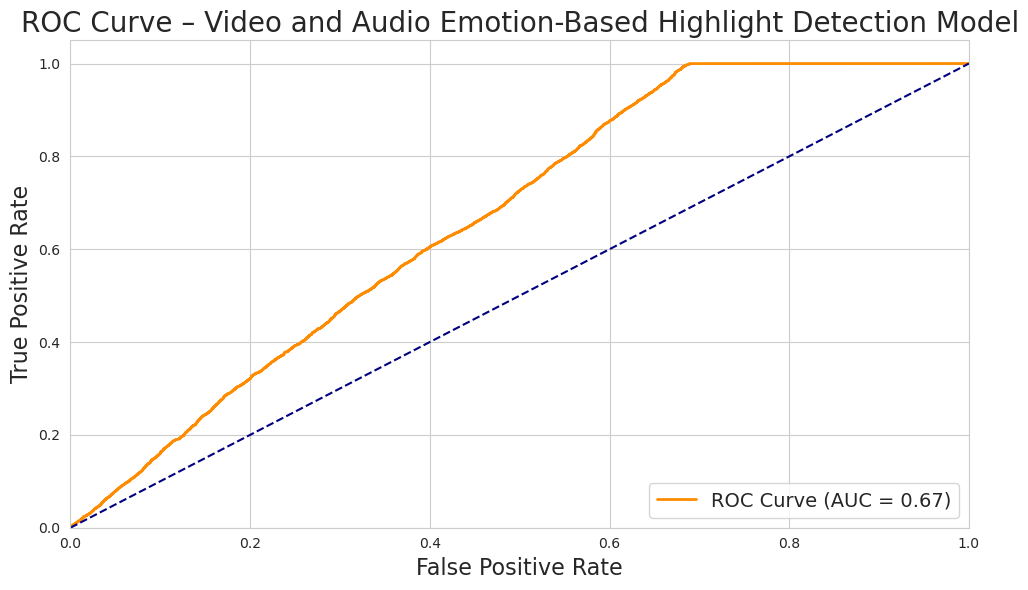

In [74]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

# === Evaluation on Test Set ===
model.eval()
y_true = []
y_score = []

with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader, desc="Evaluating on Test Set"):
        if inputs.shape[1] != labels.shape[1]:
            continue
        inputs = inputs.transpose(0, 1).to(device)
        labels = labels.squeeze(0).to(device)

        logits, _ = model(inputs)                    # raw logits
        logits = logits.squeeze(1)

        probs = torch.sigmoid(logits)                # convert to probabilities
        y_score.extend(probs.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# === Convert to NumPy arrays ===
y_true = np.array(y_true)
y_score = np.array(y_score)

# === ROC Curve ===
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC Curve – Video and Audio Emotion-Based Highlight Detection Model', fontsize=20)
plt.legend(loc="lower right", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


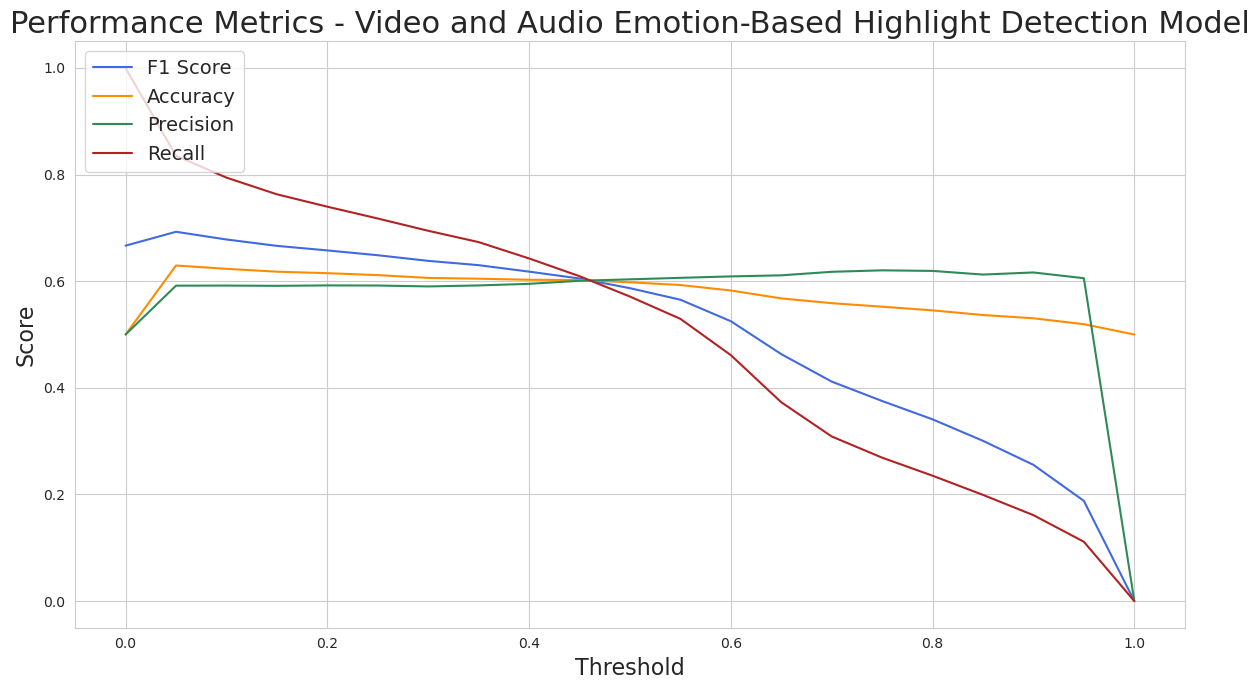

In [90]:
from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score
)
import pandas as pd
import seaborn as sns

# === Threshold-based Metric Calculation ===
thresholds = np.arange(0.0, 1.05, 0.05)
results = {
    'Threshold': [],
    'F1 Score': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': []
}

for t in thresholds:
    y_pred = (y_score > t).astype(int)
    results['Threshold'].append(t)
    results['F1 Score'].append(f1_score(y_true, y_pred, zero_division=0))
    results['Accuracy'].append(accuracy_score(y_true, y_pred))
    results['Precision'].append(precision_score(y_true, y_pred, zero_division=0))
    results['Recall'].append(recall_score(y_true, y_pred, zero_division=0))

df_metrics = pd.DataFrame(results)

# === Plot Threshold-based Metrics ===
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))
plt.plot(df_metrics['Threshold'], df_metrics['F1 Score'], label='F1 Score', color='royalblue', linestyle='-')
plt.plot(df_metrics['Threshold'], df_metrics['Accuracy'], label='Accuracy', color='darkorange', linestyle='-')
plt.plot(df_metrics['Threshold'], df_metrics['Precision'], label='Precision', color='seagreen', linestyle='-')
plt.plot(df_metrics['Threshold'], df_metrics['Recall'], label='Recall', color='firebrick', linestyle='-')

plt.title("Performance Metrics - Video and Audio Emotion-Based Highlight Detection Model", fontsize=22)
plt.xlabel("Threshold", fontsize=16)
plt.ylabel("Score", fontsize=16)
plt.legend(loc="upper left", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [76]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# 1. numpy 배열로 변환
y_true = np.array(y_true)
y_score = np.array(y_score)

# 2. 결과 저장용 리스트
thresholds = np.arange(0, 1.05, 0.05)
results = {
    "Threshold": [],
    "F1 Score": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": []
}

# 3. Threshold 별로 성능 계산
for th in thresholds:
    preds = (y_score > th).astype(int)

    f1 = f1_score(y_true, preds, zero_division=0)
    acc = accuracy_score(y_true, preds)
    prec = precision_score(y_true, preds, zero_division=0)
    rec = recall_score(y_true, preds, zero_division=0)

    results["Threshold"].append(th)
    results["F1 Score"].append(f1)
    results["Accuracy"].append(acc)
    results["Precision"].append(prec)
    results["Recall"].append(rec)

# 4. DataFrame 으로 출력
df_metrics = pd.DataFrame(results)
print(df_metrics)


    Threshold  F1 Score  Accuracy  Precision    Recall
0        0.00  0.666667  0.500000   0.500000  1.000000
1        0.05  0.692725  0.629440   0.591676  0.835398
2        0.10  0.678287  0.623245   0.591824  0.794336
3        0.15  0.666323  0.617876   0.591350  0.763068
4        0.20  0.657784  0.615103   0.592124  0.739823
5        0.25  0.648747  0.611445   0.591922  0.717640
6        0.30  0.638192  0.606195   0.590235  0.694631
7        0.35  0.630120  0.604720   0.592074  0.673392
8        0.40  0.617994  0.602714   0.595105  0.642714
9        0.45  0.605084  0.602242   0.600791  0.609440
10       0.50  0.586930  0.597994   0.603541  0.571209
11       0.55  0.565291  0.592861   0.606351  0.529440
12       0.60  0.525008  0.582596   0.609034  0.461357
13       0.65  0.463218  0.567788   0.611057  0.372979
14       0.70  0.411737  0.558820   0.617654  0.308791
15       0.75  0.375309  0.552212   0.620408  0.269027
16       0.80  0.340888  0.545310   0.619329  0.235162
17       0

In [78]:
print(model_path)

Model/Multimodal/video+audio_emotion_highlight_detection_20250422_0750.pt


In [79]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,6))  # 크기를 조절하여 더 깔끔하게 보이게 합니다.
plt.plot(train_loss, color='royalblue')  # royalblue는 전문적이면서도 보기 좋은 파란색입니다.
plt.title("Training Loss Trend: Multimodal Waveform AE + V", fontsize=16)  
plt.xlabel("Epochs", fontsize=14)  # x축 라벨 추가
plt.ylabel("Loss", fontsize=14)  # y축 라벨 추가
plt.grid(True, which="both", linestyle='--', linewidth=0.5)  # 그리드 추가
plt.tight_layout()  # 레이아웃 최적화
plt.show()


NameError: name 'train_loss' is not defined

<Figure size 1000x600 with 0 Axes>

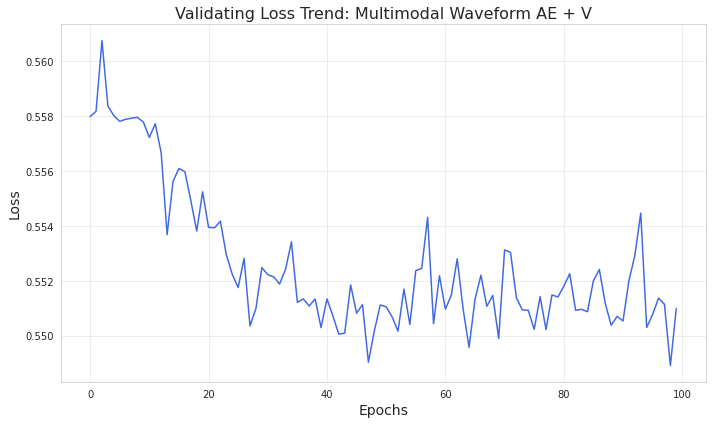

In [111]:

plt.figure(figsize=(10,6))  # 크기를 조절하여 더 깔끔하게 보이게 합니다.
plt.plot(test_loss, color='royalblue')  # royalblue는 전문적이면서도 보기 좋은 파란색입니다.
plt.title("Validating Loss Trend: Multimodal Waveform AE + V", fontsize=16)  
plt.xlabel("Epochs", fontsize=14)  # x축 라벨 추가
plt.ylabel("Loss", fontsize=14)  # y축 라벨 추가
plt.grid(True, which="both", linestyle='--', linewidth=0.5)  # 그리드 추가
plt.tight_layout()  # 레이아웃 최적화
plt.show()


In [112]:
outputs[:5]

tensor([0.4242, 0.4242, 0.4079, 0.4242, 0.4242], device='cuda:0')

# model save

In [77]:
import torch
from datetime import datetime
import os

current_time = datetime.now().strftime("%Y%m%d_%H%M")
save_dir = "Model/Multimodal"
os.makedirs(save_dir, exist_ok=True)  # 디렉토리가 없으면 생성

model_path = os.path.join(save_dir, f"video+audio_emotion_highlight_detection_{current_time}.pt")
torch.save(model.state_dict(), model_path)

